# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных:
Данные геологоразведки трёх регионов находятся в файлах: 

    geo_data_0.csv. 
    geo_data_1.csv. 
    geo_data_2.csv. 
    id — уникальный идентификатор скважины;
    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
# загрузим необходимые библиотеки
!pip install pandas
!pip install --upgrade scikit-learn==1.4 -q
!pip install --upgrade shap -q
!pip install matplotlib
!pip install phik seaborn -q

import pandas as pd
import numpy as np

import shap
from sklearn.model_selection import train_test_split

# загрузим библиотеки для построения графики
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from phik import phik_matrix

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler, Normalizer, FunctionTransformer
from sklearn.compose import ColumnTransformer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error, r2_score

# загружаем нужные модели

from sklearn.linear_model import LinearRegression

# изменим формат представления чисел с плавающей точкой
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
# загрузим данные
geo_0_df=pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
geo_1_df=pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
geo_2_df=pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
geo_0_df.head()

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


In [4]:
geo_0_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
geo_1_df.head()

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


In [6]:
geo_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_2_df.head()

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


In [8]:
geo_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
# сделаем столбец id индексом
geo_0_df=geo_0_df.set_index('id')
geo_1_df=geo_1_df.set_index('id')
geo_2_df=geo_2_df.set_index('id')

In [10]:
# проверим данные на наличие дубликатов и удалим их, если имеются
# посмотрим есть ли дубликаты и удалим их
print(geo_0_df.duplicated().sum())
print(geo_1_df.duplicated().sum())
print(geo_2_df.duplicated().sum())

0
0
0


Вывод: загружены 3 набора данных о месторождениях в 3-х регионах. В каждом датасете информация о 100 000 месторождениях одного региона. Данные не требуют обработки: типы данных в порядке, дубликатов нет. Перейдем к исследовательскому анализу данных.

## Исследовательский анализ данных

### geo_0_df

In [11]:
# выведем описание
geo_0_df.describe()

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


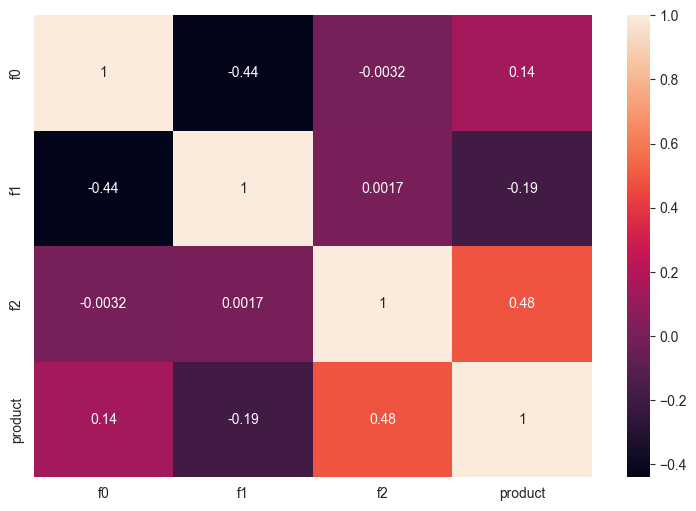

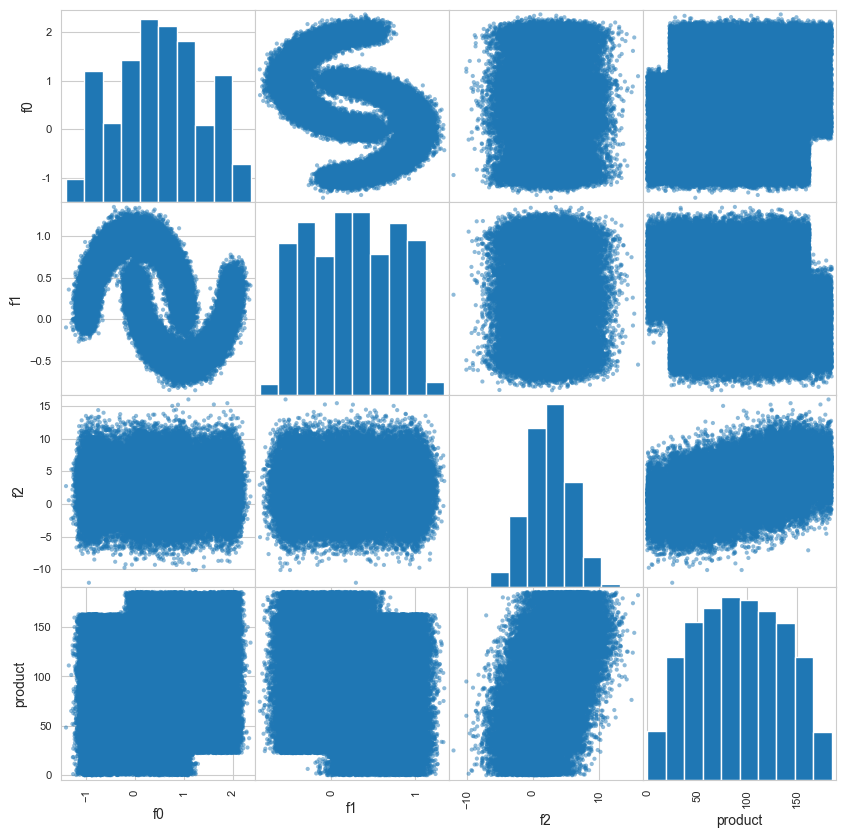

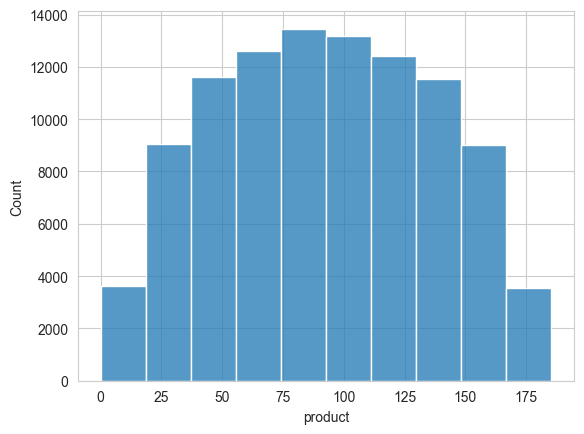

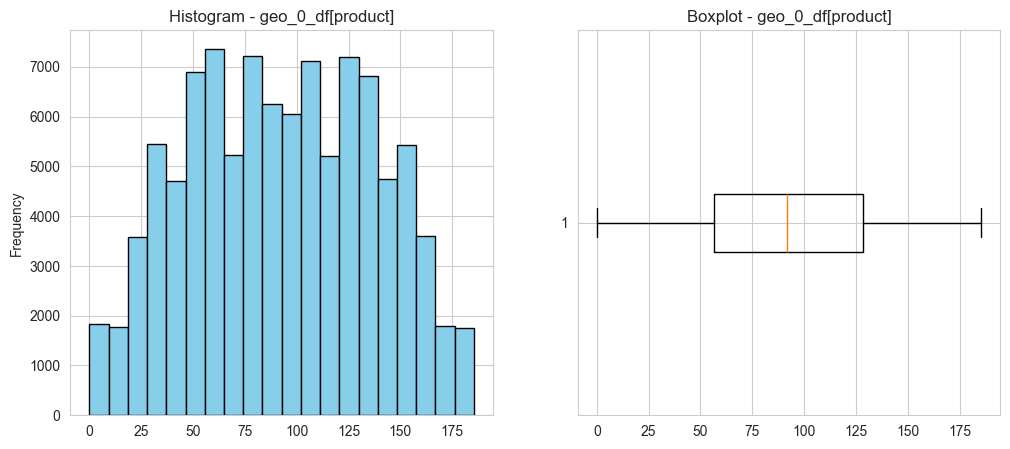

In [12]:
# построим матрицу корреляции
corr_matrix = geo_0_df.corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr_matrix, annot=True)
plt.show()
# Посмотрим рассеяние признаков в датасете geo_0_df
pd.plotting.scatter_matrix(geo_0_df, figsize=(10, 10))
plt.show()
sns.histplot(geo_0_df['product'], bins=10)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].set_title(f'Histogram - geo_0_df[product]')
axes[0].hist(geo_0_df['product'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_ylabel('Frequency')

axes[1].set_title(f'Boxplot - geo_0_df[product]')
axes[1].boxplot(geo_0_df['product'], vert=False)
plt.show()

У целевого признака с признаком f2 наблюдается наиболее сильная связь, а признаки f0 и f1 имеют нелинейную связь. Целевой признак имеет нормальное распределение.

### geo_1_df

In [13]:
# выведем описание
geo_1_df.describe()

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


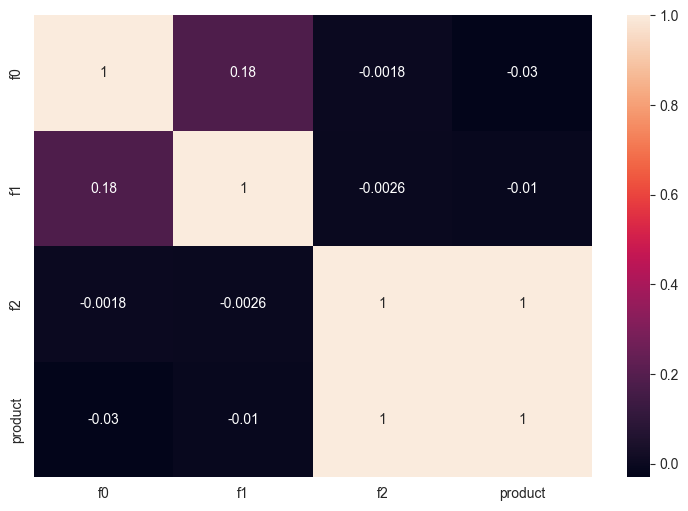

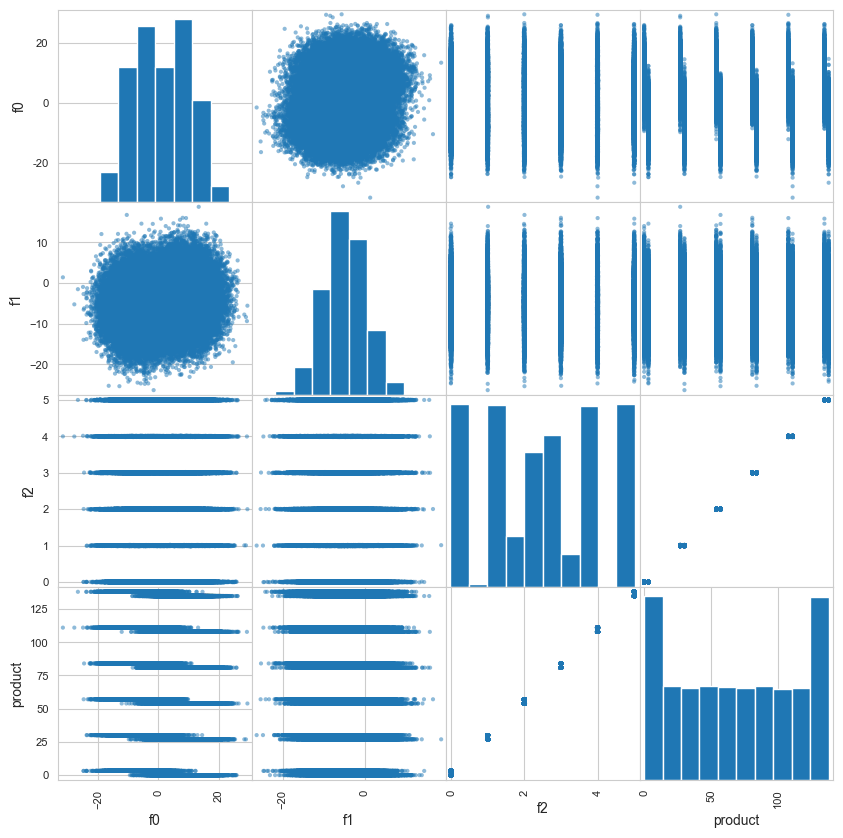

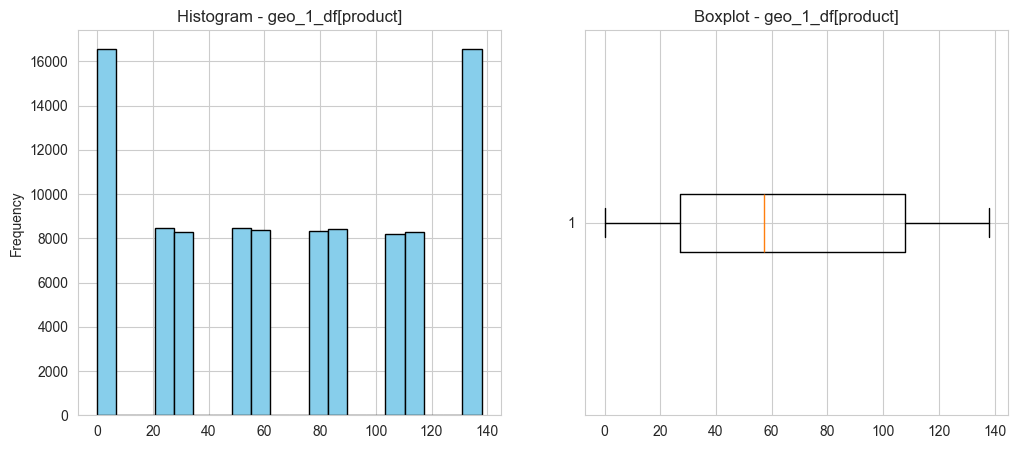

In [14]:
# построим матрицу корреляции
corr_matrix = geo_1_df.corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr_matrix, annot=True)
plt.show()
# Посмотрим рассеяние признаков в датасете geo_1_df
pd.plotting.scatter_matrix(geo_1_df, figsize=(10, 10))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].set_title(f'Histogram - geo_1_df[product]')
axes[0].hist(geo_1_df['product'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_ylabel('Frequency')

axes[1].set_title(f'Boxplot - geo_1_df[product]')
axes[1].boxplot(geo_1_df['product'], vert=False)
plt.show()

Целевой признак имеет сильную линейную зависимость с f2, целевой признак имеет ненормальное распределение.

### geo_2_df

In [15]:
# выведем описание
geo_2_df.describe()

,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


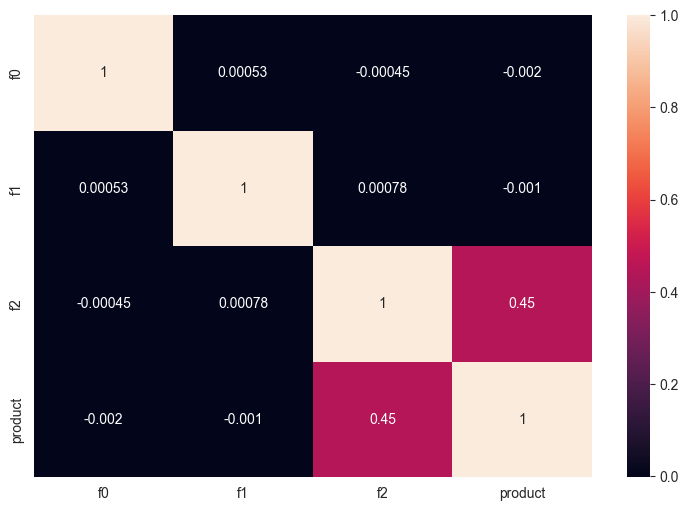

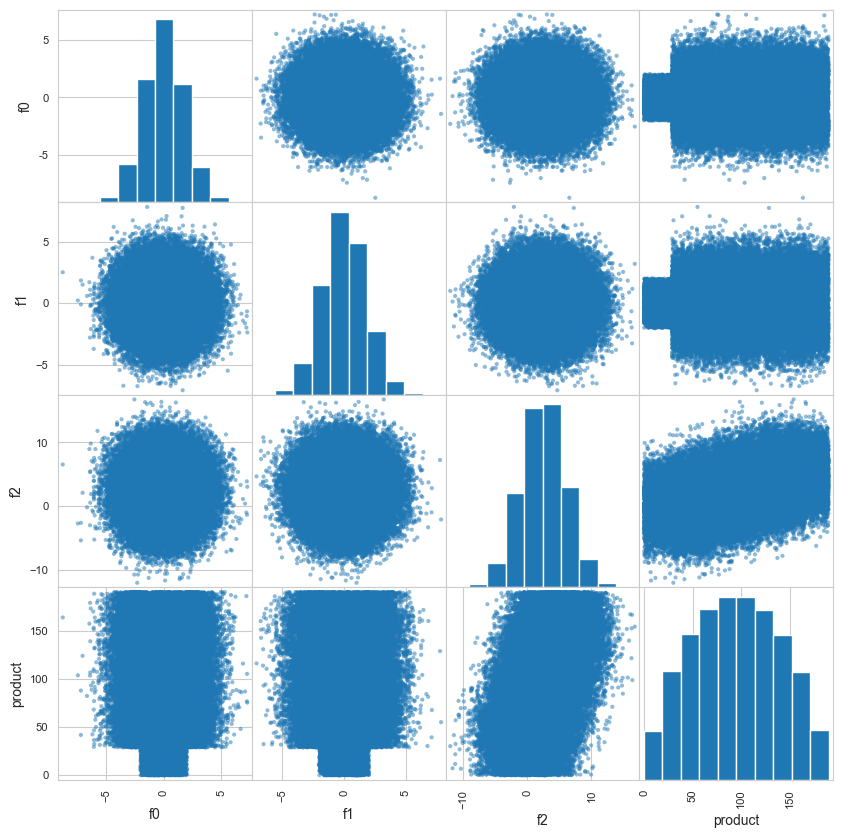

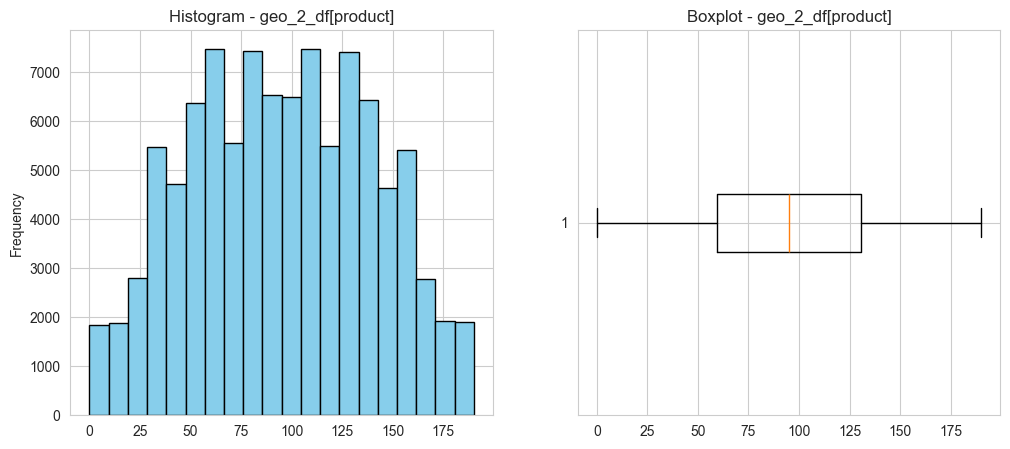

In [16]:
# построим матрицу корреляции
corr_matrix = geo_2_df.corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr_matrix, annot=True)
plt.show()
# Посмотрим рассеяние признаков в датасете geo_2_df
pd.plotting.scatter_matrix(geo_2_df, figsize=(10, 10))
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].set_title(f'Histogram - geo_2_df[product]')
axes[0].hist(geo_2_df['product'], bins=20, color='skyblue', edgecolor='black')
#axes[0].set_xlabel(geo_2_df['product'])
axes[0].set_ylabel('Frequency')

axes[1].set_title(f'Boxplot - geo_2_df[product]')
axes[1].boxplot(geo_2_df['product'], vert=False)
#axes[1].set_xlabel(geo_2_df['product'])
plt.show()

Целевой признак имеет прямую линейную зависимость с признаком f2, целевой признак имеет нормальное распределение

**Вывод:** Во всех трех датасетах наблюдается линейная зависимость целевого признака от признака f2. В некоторых датасетах прослеживается более явная зависимость признаков друг от друга. Выбросов в целевом признаке во всех трех датасетах не наблюдается.

## Обучение и проверка модели

### Поиск лучшей модели и гиперпараметров для датасета geo_0_df

In [17]:
# разделим датасет geo_0_df на обучающую и тестовую выборки
RANDOM_STATE = 42
y=geo_0_df['product']
X=geo_0_df.drop('product', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [18]:
display(y_train)
X_train

id
VZVnq   105.18
EC6JJ     9.35
PIII5   117.27
80ZC3   116.54
jZDSd   110.71
         ...  
pzVvZ   131.20
0Dtx5    86.90
cZDx4   156.87
8IHAp    83.76
zE92l    47.08
Name: product, Length: 75000, dtype: float64

,f0,f1,f2
id,,,
VZVnq,1.61,-0.15,1.22
EC6JJ,-0.90,0.37,-4.54
PIII5,0.22,0.97,7.37
80ZC3,0.88,0.67,3.11
jZDSd,-0.94,0.63,2.87
...,...,...,...
pzVvZ,1.63,-0.11,2.95
0Dtx5,1.68,-0.19,-1.18
cZDx4,0.98,-0.55,2.90


In [19]:
# создадим пайплайн для обработки и моделирования
# cоздаём пайплайн для масштабирования
scaler_pipe = Pipeline(steps=[
    ('scaler', 'passthrough')  # 'passthrough' означает, что масштабировщик будет выбран позже
])

In [20]:
# Объединяем кодирование и масштабирование в один пайплан
#preprocessing = ColumnTransformer(
#    [
 #       ('poly', poly_pipe ),
#        ('scaler', scaler_pipe)
#    ], 
#    remainder='passthrough'
#) 

In [21]:
# нам необходимо подобрать лучшие параметры модели ориентируясь на метрику rmse, создадим метрику
score_rmse=make_scorer(root_mean_squared_error, greater_is_better=False)
score_r2=make_scorer(r2_score, greater_is_better=True)
# Напишем функцию для вычисления новой метрики качества SMAPE - симметричное среднее абсолютное процентное отклонение
def calculate_smape(y_true, y_pred):
   return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
score_smape=make_scorer(calculate_smape, greater_is_better=False )

In [22]:
# Создадим итоговый пайплайн c моделью LinearRegression
pipe_final_linear = Pipeline(
    [
        ('poly', PolynomialFeatures()),
        ('scaler', scaler_pipe),
        ('models', LinearRegression())
    ]
)

In [23]:
# Подбор гиперпараметров для множественной линейной модели
param_grid_linear = {
    'poly__degree': [5,6,7],
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer(), 'passthrough']
                    }

linear_pipeline_cv = GridSearchCV(pipe_final_linear, param_grid_linear, scoring=score_rmse, cv=5, n_jobs=-1)
linear_pipeline_cv.fit(X_train, y_train)

best_model=linear_pipeline_cv.best_estimator_
best_params=linear_pipeline_cv.best_params_

print('Лучшие гиперпараметры:\n\n', best_params)
print ('Метрика rmse лучшей модели на тренировочной выборке:', linear_pipeline_cv.best_score_)
print('Метрика r2:', cross_val_score(linear_pipeline_cv, X_train, y_train, cv=5, scoring=score_r2).mean() )
print('Метрика smape:', cross_val_score(linear_pipeline_cv, X_train, y_train, cv=5, scoring=score_smape).mean() )

Лучшие гиперпараметры:

 {'poly__degree': 7, 'scaler': 'passthrough'}
Метрика rmse лучшей модели на тренировочной выборке: -37.066770463407295
Метрика r2: 0.2995289131145237
Метрика smape: -38.453452426881725


Были подобраны лучшие параметры модели: 'poly__degree': 7, 'scaler': 'passthrough'. Использована полиномизация, с целью уловить нелинейные связи и усилить их влияние, это дало положительный результат, качество модели улучшилось, но все еще низкое: погрешность большая : 37 тыс. баррелей, r2 = 0.3. Так же была предпринята попытка feature engineering путем умножения f0 на f1, но это не повлияло на качество модели.

In [24]:
# Посмотрим на качество предсказания на тестовой выборке
y_pred_0=best_model.predict(X_test)

print('Метрика rmse на тестовой выборке:', root_mean_squared_error(y_test, y_pred_0))
print('Метрика r2 на тестовой выборке:',r2_score(y_test, y_pred_0))
print('Средний запас сырья(тыс.баррелей):', y_pred_0.mean())
y_pred_0=pd.DataFrame(y_pred_0, index=y_test.index, columns=['product'])
y_test=pd.DataFrame(y_test, columns=['product'])

Метрика rmse на тестовой выборке: 37.173773383495245
Метрика r2 на тестовой выборке: 0.29510531097565296
Средний запас сырья(тыс.баррелей): 92.47156093577199


Качество модели на тестовой выборке такое же, как и на тренировочной.

In [25]:
# проведем анализ остатков
residuals = y_test['product']-y_pred_0['product']
residuals.head()

id
7C6bA    23.50
dVxsn   -29.90
1Gm3l    18.40
Nzg1t   -18.48
Z7b4F   -48.89
Name: product, dtype: float64

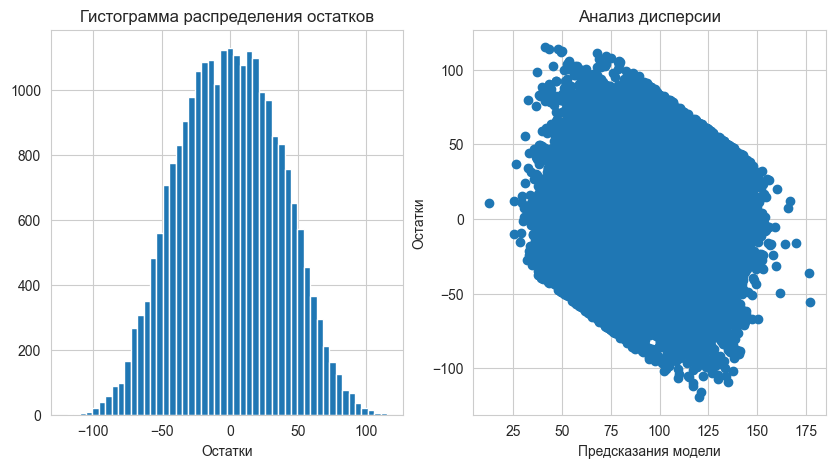

In [26]:
# Проанализируем остатки
# построим гистрограмму распределения остатков и диаграмму расеяния остатков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred_0,y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Гистограмма распределения остатков имеет нормальное распределение и на диаграмме рассеяния остатков не нвблюдается зависимостей. Значит модель хоть и не очень качествена, но стабильна.
Для датасета geo_0_df выберем модель Линейной регрессии с параметрами: 'poly__degree': 7, 'scaler': 'passthrough'

### Поиск лучшей модели и гиперпараметров для датасета geo_1_df

In [27]:
# разделим датасет geo_1_df на обучающую и тестовую выборки
y=geo_1_df['product']
X=geo_1_df.drop('product', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [28]:
# Подбор гиперпараметров для множественной линейной модели
param_grid_linear = {
    'poly__degree': [5,6,7],
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer(), 'passthrough']
                    }

linear_pipeline_cv = GridSearchCV(pipe_final_linear, param_grid_linear, scoring=score_rmse, cv=5, n_jobs=-1)
linear_pipeline_cv.fit(X_train, y_train)

best_model=linear_pipeline_cv.best_estimator_
best_params=linear_pipeline_cv.best_params_

print('Лучшие гиперпараметры:\n\n', best_params)
print ('Метрика rmse лучшей модели на тренировочной выборке:', linear_pipeline_cv.best_score_)
print('Метрика r2:', cross_val_score(linear_pipeline_cv, X_train, y_train, cv=5, scoring=score_r2).mean() )
print('Метрика smape:', cross_val_score(linear_pipeline_cv, X_train, y_train, cv=5, scoring=score_smape).mean() )

Лучшие гиперпараметры:

 {'poly__degree': 7, 'scaler': RobustScaler()}
Метрика rmse лучшей модели на тренировочной выборке: -0.7301768726891744
Метрика r2: 0.9997473893096931
Метрика smape: -18.402885161071865


Модель показывает идеальные результаты, что сомнительно, но на графиках мы видели прямую четкую линейную зависимость целевого признака от f2, поэтому полученный результат может быть правдой. Лучшие параметры:'poly__degree': 7, 'scaler': RobustScaler(). 

In [29]:
# Посмотрим на качество предсказания на тестовой выборке
y_pred_1=best_model.predict(X_test)

print('Метрика rmse на тестовой выборке:', root_mean_squared_error(y_test, y_pred_1))
print('Метрика r2 на тестовой выборке:',r2_score(y_test, y_pred_1))
print('Средний запас сырья(тыс.баррелей):', y_pred_1.mean())
y_pred_1=pd.DataFrame(y_pred_1, index=y_test.index, columns=['product'])
y_test=pd.DataFrame(y_test, columns=['product'])

Метрика rmse на тестовой выборке: 0.7296393439123939
Метрика r2 на тестовой выборке: 0.9997477993137084
Средний запас сырья(тыс.баррелей): 68.71631365987908


Как мы видим погрешность очень маленькая и на тестовых данных, значит никакой утечки нет.

In [30]:
# проведем анализ остатков
residuals = y_test['product']-y_pred_1['product']

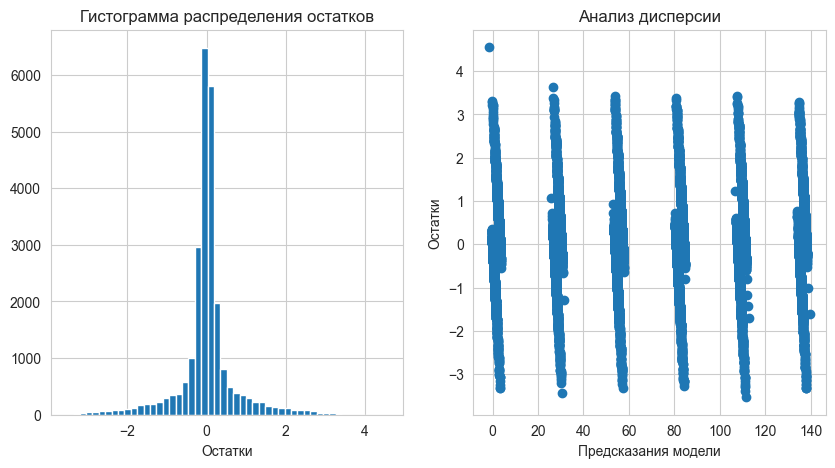

In [31]:
# Проанализируем остатки
# построим гистрограмму распределения остатков и диаграмму расеяния остатков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred_1,y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Гистограмма распределения остатков имеет нормальное распределение и на диаграмме рассеяния остатков остатки распределяются равномерно на всех предсказаниях модели. Значит модель качествена и стабильна.
Для датасета geo_1_df выберем модель Линейной регрессии с параметрами: 'poly__degree': 7, 'scaler': RobustScaler().

### Поиск лучшей модели и гиперпараметров для датасета geo_2_df

In [32]:
# разделим датасет geo_2_df на обучающую и тестовую выборки
y=geo_2_df['product']
X=geo_2_df.drop('product', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [33]:
# Подбор гиперпараметров для множественной линейной модели
param_grid_linear = {
    'poly__degree': [1,2,3,4,5,6,7],
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer(), 'passthrough']
                    }

linear_pipeline_cv = GridSearchCV(pipe_final_linear, param_grid_linear, scoring=score_rmse, cv=5, n_jobs=-1)
linear_pipeline_cv.fit(X_train, y_train)

best_model=linear_pipeline_cv.best_estimator_
best_params=linear_pipeline_cv.best_params_

print('Лучшие гиперпараметры:\n\n', best_params)
print ('Метрика rmse лучшей модели на тренировочной выборке:', linear_pipeline_cv.best_score_)
print('Метрика r2:', cross_val_score(linear_pipeline_cv, X_train, y_train, cv=5, scoring=score_r2).mean() )
print('Метрика smape:', cross_val_score(linear_pipeline_cv, X_train, y_train, cv=5, scoring=score_smape).mean() )

Лучшие гиперпараметры:

 {'poly__degree': 6, 'scaler': 'passthrough'}
Метрика rmse лучшей модели на тренировочной выборке: -38.04797988282571
Метрика r2: 0.2766243204868882
Метрика smape: -38.16863364001976


Были подобраны лучшие параметры модели: 'poly__degree': 6, 'scaler': 'passthrough'. Использована полиномизация, с целью уловить нелинейные связи и усилить их влияние, это дало положительный результат, качество модели улучшилось, но все еще низкое: погрешность большая : 38 тыс. баррелей, r2 = 0.28. 

In [34]:
# Посмотрим на качество предсказания на тестовой выборке
y_pred_2=best_model.predict(X_test)

print('Метрика rmse на тестовой выборке:', root_mean_squared_error(y_test, y_pred_2))
print('Метрика r2 на тестовой выборке:',r2_score(y_test, y_pred_2))
print('Средний запас сырья(тыс.баррелей):', y_pred_2.mean())
y_pred_2=pd.DataFrame(y_pred_2, index=y_test.index, columns=['product'])
y_test=pd.DataFrame(y_test, columns=['product'])

Метрика rmse на тестовой выборке: 38.11722896946642
Метрика r2 на тестовой выборке: 0.27551502692249485
Средний запас сырья(тыс.баррелей): 94.7814796387922


На тестовой выборке результаты такие же как и на тренировочной.

In [35]:
# проведем анализ остатков
residuals = y_test['product']-y_pred_2['product']

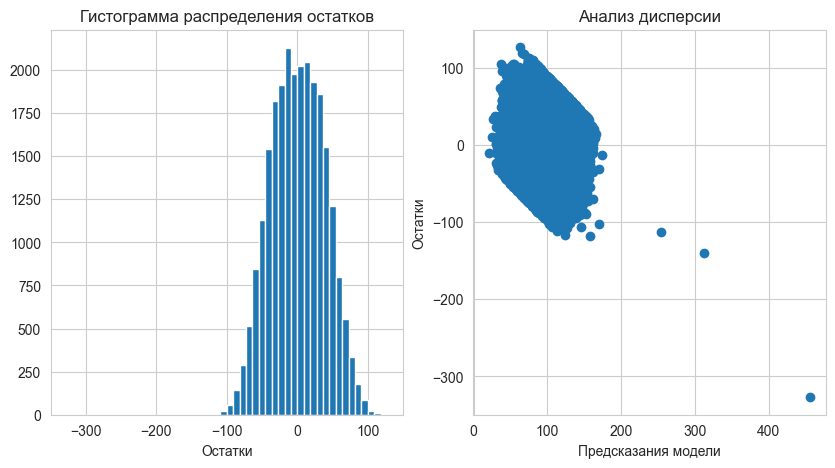

In [36]:
# Проанализируем остатки
# построим гистрограмму распределения остатков и диаграмму расеяния остатков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred_2,y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Гистограмма распределения остатков явно смещена вправо, то означает, что модель перепрогнозирует в большую сторону. На диаграмме рассеяния данных прослеживаются выбросы: чем большее значение модель предсказывает, тем больше ошибается. Была сделана попытка улучшения качества модели: удаление product ,больше 95 перцентиля, однако это только ухудшило качество модели.

В итоге мы получили 3 модели для 3 разных регионов. Качество первой и третьей модели оставляет желать лучшего, были перепробованы варианты улучшения качества с посощью создания нового признака, подбора гиперпараметров, удаление части данных, но эти попытки принесли очень маленький положительный результат. Мне кажется, это связано с ошибками в самих данных, модель не может найти зависисмость. Но, к сожалению, так как данные синтетические и не поддаются логическому анализу, я не могу добавить доп. признаки, которые возможно улучшили бы качество. Качество второй модели очень высокое.

## Подготовка к расчёту прибыли

Условия задачи:

    Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
    При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
    Бюджет на разработку скважин в регионе — 10 млрд рублей.
    При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
    После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [37]:
# запишем основные константы в переменные
POINTS_NUM=500
SEL_POINTS_NUM=200
BUDGET=10_000_000_000
REVENUE_PER_BAR=450000


In [38]:
# добавим выручку в датасеты
y_pred_0['revenue']=y_pred_0['product']*REVENUE_PER_BAR
y_pred_1['revenue']=y_pred_1['product']*REVENUE_PER_BAR
y_pred_2['revenue']=y_pred_2['product']*REVENUE_PER_BAR

In [39]:
# рассчитаем точку безубыточности
break_even=round(BUDGET/SEL_POINTS_NUM/REVENUE_PER_BAR,2)
print("Достаточный объём сырья для безубыточной разработки новой скважины.",break_even, "тыс.баррелей")

Достаточный объём сырья для безубыточной разработки новой скважины. 111.11 тыс.баррелей


In [40]:
# добавим потенциальную прибыль в датасеты
y_pred_0['pot_profit']=y_pred_0['revenue']-break_even*REVENUE_PER_BAR
y_pred_1['pot_profit']=y_pred_1['revenue']-break_even*REVENUE_PER_BAR
y_pred_2['pot_profit']=y_pred_2['revenue']-break_even*REVENUE_PER_BAR

In [41]:
# выведем среднее значение запасов в каждом регионе
print("Ср. запас сырья в geo_0_df", round(y_pred_0['product'].mean(),2))
print("Ср. запас сырья в geo_1_df", round(y_pred_1['product'].mean(),2))
print("Ср. запас сырья в geo_2_df", round(y_pred_2['product'].mean(),2))

Ср. запас сырья в geo_0_df 92.47
Ср. запас сырья в geo_1_df 68.72
Ср. запас сырья в geo_2_df 94.78


Во всех трех регионах ср. запас сырья ниже точки безубыточности, более достоверная информация по датасету, так как качество предсказания, как мы помним там очень высокое. В третьей моделе(датасете) анализ остатков показал, что модель перепрогнозирует уелевые значения в большую сторону, поэтому ср. запас там скорее всего меньше, чем 94.78.

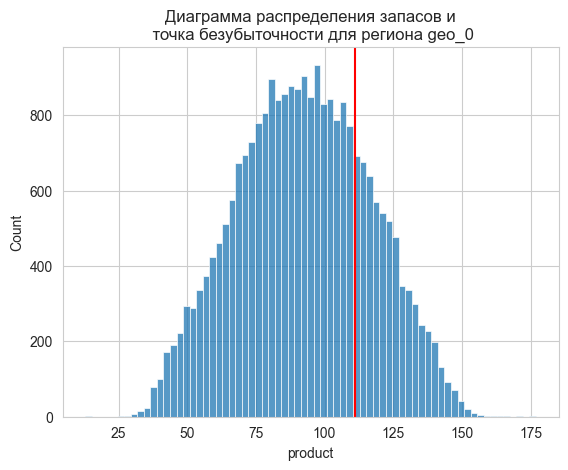

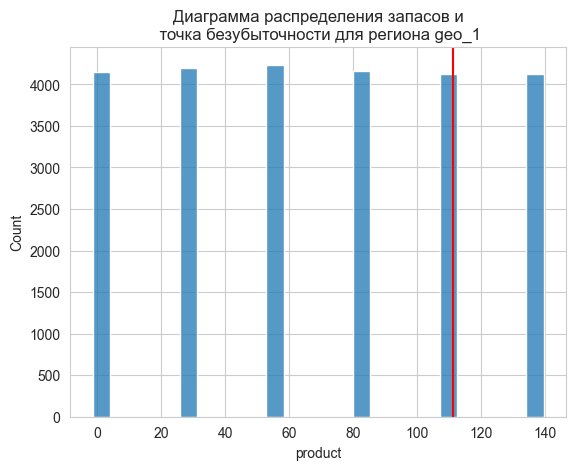

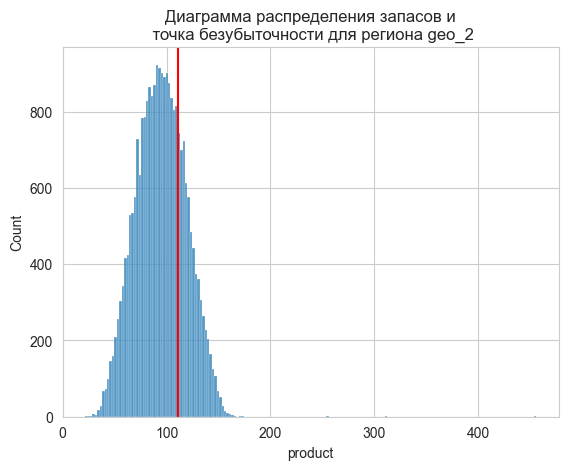

In [42]:
# Посмотрим распределение запасов в скважинах и сравним с точкой безубыточности
sns.histplot(y_pred_0['product']).axvline(break_even, color='r')
plt.title('Диаграмма распределения запасов и\n точка безубыточности для региона geo_0')
plt.show()
sns.histplot(y_pred_1['product']).axvline(break_even, color='r')
plt.title('Диаграмма распределения запасов и\n точка безубыточности для региона geo_1')
plt.show()
sns.histplot(y_pred_2['product']).axvline(break_even, color='r')
plt.title('Диаграмма распределения запасов и\n точка безубыточности для региона geo_2')
plt.show() 

В итоге была рассчитана точка безубыточности: 111,11 тыс. баррелей. Оценивая визульно под эти условия подходят менее 50% скважин в каждом регионе, и это еще без учета рисков.

## Расчёт прибыли и рисков 

In [43]:
# отберем по 500 наиболее прибыльных скважин в каждом регионе
sel_geo_0=y_pred_0.sort_values(by='product',ascending=False).head(SEL_POINTS_NUM)
display(sel_geo_0)
print("Суммарный объем сырья:",round(sel_geo_0['product'].sum(),0))
print("Суммарная прибыль:",round(sel_geo_0['pot_profit'].sum(),0))

,product,revenue,pot_profit
id,,,
gfNEs,176.97,"79,637,199.80","29,637,699.80"
WcCwe,176.75,"79,538,651.71","29,539,151.71"
lfgbR,170.01,"76,503,689.81","26,504,189.81"
he3xS,166.85,"75,084,486.65","25,084,986.65"
VDESo,166.01,"74,705,631.89","24,706,131.89"
...,...,...,...
t2gsW,145.14,"65,312,612.09","15,313,112.09"
0wtS0,145.07,"65,280,414.70","15,280,914.70"
pMWhN,145.03,"65,265,484.57","15,265,984.57"


Суммарный объем сырья: 29898.0
Суммарная прибыль: 3454184913.0


In [44]:
sel_geo_1=y_pred_1.sort_values(by='product',ascending=False).head(SEL_POINTS_NUM)
display(sel_geo_1)
print("Суммарный объем сырья:",round(sel_geo_1['product'].sum(),0))
print("Суммарная прибыль:",round(sel_geo_1['pot_profit'].sum(),0))

,product,revenue,pot_profit
id,,,
qXVl2,139.54,"62,794,575.95","12,795,075.95"
kpPCd,138.96,"62,530,665.27","12,531,165.27"
xDAeX,138.47,"62,309,521.50","12,310,021.50"
JQEVL,138.41,"62,282,559.94","12,283,059.94"
OdFn6,138.37,"62,268,519.48","12,269,019.48"
...,...,...,...
7QTFK,138.07,"62,130,800.36","12,131,300.36"
ypuKf,138.07,"62,130,581.67","12,131,081.67"
cJ0kc,138.07,"62,130,443.70","12,130,943.70"


Суммарный объем сырья: 27623.0
Суммарная прибыль: 2430644501.0


In [45]:
sel_geo_2=y_pred_2.sort_values(by='product',ascending=False).head(SEL_POINTS_NUM)
display(sel_geo_2)
print("Суммарный объем сырья:",round(sel_geo_2['product'].sum(),0))
print("Суммарная прибыль:",round(sel_geo_2['pot_profit'].sum(),0))

,product,revenue,pot_profit
id,,,
Ttv5F,455.65,"205,042,207.89","155,042,707.89"
herpN,311.70,"140,264,696.86","90,265,196.86"
fSFdX,254.69,"114,610,723.05","64,611,223.05"
0Chlx,173.90,"78,255,665.84","28,256,165.84"
ykzIb,170.59,"76,765,759.83","26,766,259.83"
...,...,...,...
n7AFQ,148.25,"66,714,326.44","16,714,826.44"
wsgyu,148.13,"66,657,260.82","16,657,760.82"
6JwiV,148.10,"66,646,617.25","16,647,117.25"


Суммарный объем сырья: 31157.0
Суммарная прибыль: 4020647461.0


Очевидно, что наиболее выгодным для разработки является третий регион.Однако для надежности, нам нужн учитывать % рисков.

In [46]:
# найдем распределение прибыли, применив технику bootstrap c 1000 выборок
from numpy.random import RandomState
state = RandomState(12345) 
def revenue(target, revenue, count):
    selected_index = target['pot_profit'].sort_values(ascending=False)[:count]
    selected = revenue[selected_index.index]
    return selected.sum()*REVENUE_PER_BAR-BUDGET
    
values = []
for i in range(1000):
    target_subsample = y_pred_0.sample(n=POINTS_NUM, replace=True, random_state=state)
    values.append(revenue(target_subsample,geo_0_df['product'], SEL_POINTS_NUM))

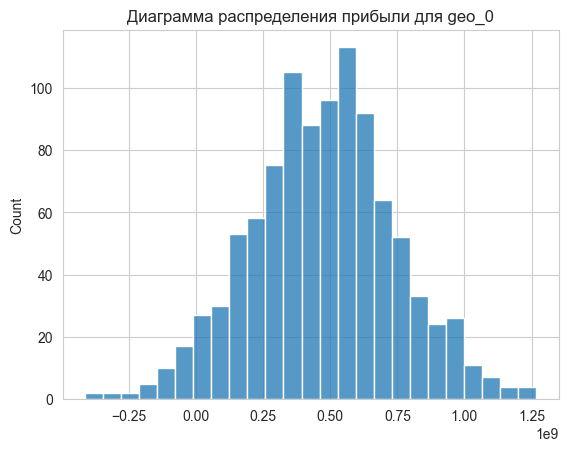

In [47]:
sns.histplot(values)
plt.title('Диаграмма распределения прибыли для geo_0')
plt.show()

In [48]:
# рассчитаем риск убытков, верхнюю и нижнюю границу 95% доверительного интервала и сре. прибыль

values = pd.Series(values)

percentage_negative = (values < 0).mean() * 100

lower = values.quantile(0.025)
upper = values.quantile(0.975)

print('Нижняя граница 95% интервала в регионе geo_0:',lower)
print('Верхняя граница 95% интервала в регионе geo_0:',upper)
print('Средняя прибыль в регионе geo_0:', values.mean())
print('Риск убытков в регионе geo_0:', round(percentage_negative,2),'%')

Нижняя граница 95% интервала в регионе geo_0: -62948070.48155751
Верхняя граница 95% интервала в регионе geo_0: 1002130328.1665015
Средняя прибыль в регионе geo_0: 472463344.9256204
Риск убытков в регионе geo_0: 4.2 %


In [49]:
# geo_1
values = []
for i in range(1000):
    target_subsample = y_pred_1.sample(n=POINTS_NUM, replace=True, random_state=state)
    values.append(revenue(target_subsample,geo_1_df['product'], SEL_POINTS_NUM))

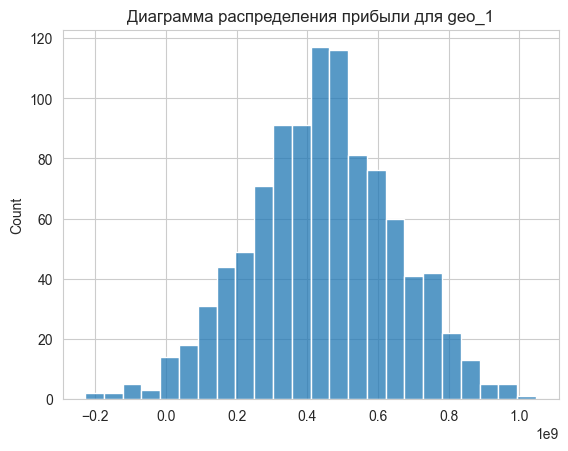

In [50]:
sns.histplot(values)
plt.title('Диаграмма распределения прибыли для geo_1')
plt.show()

In [51]:
# рассчитаем риск убытков, верхнюю и нижнюю границу 95% доверительного интервала и сре. прибыль
values = pd.Series(values)

percentage_negative = (values < 0).mean() * 100

lower = values.quantile(0.025)
upper = values.quantile(0.975)

print('Нижняя граница 95% интервала в регионе geo_1:',lower)
print('Верхняя граница 95% интервала в регионе geo_1:',upper)
print('Средняя прибыль в регионе geo_1:', values.mean())
print('Риск убытков в регионе geo_1:', round(percentage_negative,2),'%')

Нижняя граница 95% интервала в регионе geo_1: 35728489.280851334
Верхняя граница 95% интервала в регионе geo_1: 830874051.312591
Средняя прибыль в регионе geo_1: 442561114.95730144
Риск убытков в регионе geo_1: 1.6 %


In [52]:
# geo_2
values = []
for i in range(1000):
    target_subsample = y_pred_2.sample(n=POINTS_NUM, replace=True, random_state=state)
    values.append(revenue(target_subsample,geo_2_df['product'], SEL_POINTS_NUM))

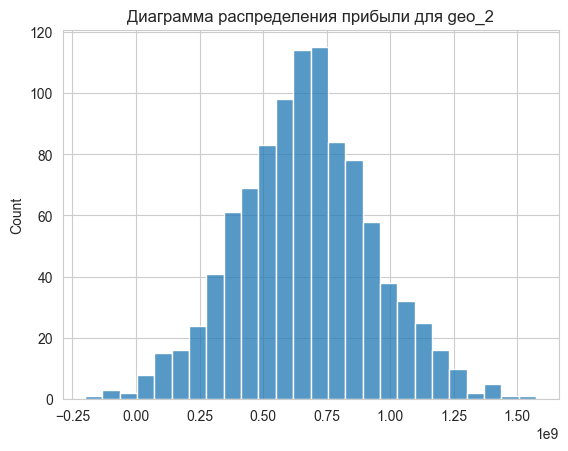

In [53]:
sns.histplot(values)
plt.title('Диаграмма распределения прибыли для geo_2')
plt.show()

In [54]:
# рассчитаем риск убытков, верхнюю и нижнюю границу 95% доверительного интервала и сре. прибыль
values = pd.Series(values)

percentage_negative = (values < 0).mean() * 100

lower = values.quantile(0.025)
upper = values.quantile(0.975)

print('Нижняя граница 95% интервала в регионе geo_2:',lower)
print('Верхняя граница 95% интервала в регионе geo_2:',upper)
print('Средняя прибыль в регионе geo_2:', values.mean())
print('Риск убытков в регионе geo_2:', round(percentage_negative,2),'%')

Нижняя граница 95% интервала в регионе geo_2: 129568511.10536413
Верхняя граница 95% интервала в регионе geo_2: 1192960471.436009
Средняя прибыль в регионе geo_2: 665594646.0179573
Риск убытков в регионе geo_2: 0.6 %


В регионе geo_0 риск убытков больше 2,5%, значит он не проходит по нашим условиям. Наиболее выгодный регион - geo_2. Там потенциальная прибыль больше всего и риск убытков меньше всего.Я бы рекомендовала развивать именно его.